In [1]:
%cd ..


/Users/eliaweiss/ai/segmentation/MobileSAM


In [2]:
import numpy as np
from tblDetect.TableDetect import TableDetect
from tblDetect.MobileSamBoxes import MobileSamBoxes
import matplotlib.pyplot as plt
from PIL import Image
from notebooks.Utils import plot_results, \
    plot_rotatedResult, \
        applyRotatedResult , \
        plot_annotations 
from tblDetect.AlignTable_Processor import AlignTable_Processor
from tblDetect.TblStructureDetect import TblStructureDetect
import cv2
import time



/Users/eliaweiss/ai/segmentation/MobileSAM/tinyvit/tiny_vit.py:656: UserWarning: Overwriting tiny_vit_5m_224 in registry with tinyvit.tiny_vit.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/Users/eliaweiss/ai/segmentation/MobileSAM/tinyvit/tiny_vit.py:656: UserWarning: Overwriting tiny_vit_11m_224 in registry with tinyvit.tiny_vit.tiny_vit_11m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/Users/eliaweiss/ai/segmentation/MobileSAM/tinyvit/tiny_vit.py:656: UserWarning: Overwriting tiny_vit_21m_224 in registry with tinyvit.tiny_vit.tiny_vit_21m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/Users/eliaweiss/ai/segmentation/MobileSAM/tinyvit/tiny_vit.py:656: U

In [3]:
# init detectors
tblDec = TableDetect()
sam = MobileSamBoxes()
tblStructDetect = TblStructureDetect()       

checkpoint_load_scucess


In [4]:
file_list = ["/Users/eliaweiss/Documents/doc2txt/invoices 2/expense (6).jpeg", 
              "/Users/eliaweiss/Documents/doc2txt/sihach/attachments/img/20231025012642_001.jpg",
              "/Users/eliaweiss/Documents/doc2txt/sihach/need fix/4e7d4235deff4ee2b72d886e12ad0bcf.jpg"]

In [5]:
import os
folder = "/Users/eliaweiss/Documents/doc2txt/lineCv/1"
# folder = "/Users/eliaweiss/Documents/doc2txt/sihach/Invoices/3/img3"
file_list = os.listdir(folder)
file_list = [file for file in file_list if 
             ".jpg" in file 
             or ".png" in file 
             or ".jpeg" in file]


In [6]:
fileIter = iter(file_list)
cc = 0

In [7]:
while True:
    file_path = next(fileIter)
    cc+=1    
    if cc < 25:
        continue
    print(cc)
    
    file_path = os.path.join(folder, file_path)
    print(file_path)

    img_pil = Image.open(file_path)
    # Resize the image
    img_pil.thumbnail((1500, 1500))
    start = time.time()
    
    # detect table
    probas, boxes = tblDec.detectTables(img_pil)
    if len(boxes):
        # find table mask
        anns = sam.process(img_pil,boxes)
    else:
        print("no tbl found!")
        anns = []
    

 
    for ann, box, prob in zip(anns, boxes,probas):
        tmpImg = np.array(img_pil)    
        print("prob: ",f"{prob:.2}")
        alignTable_processor = AlignTable_Processor(img_pil, annotation=ann, tblBox=np.intp(box.tolist()))
        tbl_patch_pil = alignTable_processor.getAlignTable()
        cells = tblStructDetect.detectTableStructure(tbl_patch_pil)
        rotated_cells =  alignTable_processor.unRotateAllCell(cells)
        print("------ total time: (s): %s" % round(time.time() - start, 2))
    
        applyRotatedResult(tmpImg, rotated_cells)
        
        cv2.imshow("tmpImg",tmpImg)
        cv2.waitKey()
    # break

25
/Users/eliaweiss/Documents/doc2txt/lineCv/1/22.jpg
prob:  0.17
mean -0.020251875000428916 std 0.0034780135266358325 slopes[0] -0.02372988852706475
------ total time: (s): 3.0
prob:  0.11
------ total time: (s): 5.46
26
/Users/eliaweiss/Documents/doc2txt/lineCv/1/23.png
prob:  0.7
mean -0.0029204157246058957 std 0.008414921219111415 slopes[0] -0.01133533694371731
------ total time: (s): 3.51


mean 0.11072502615803848 std 0.027955758633948086 slopes[0] 0.08276926752409039


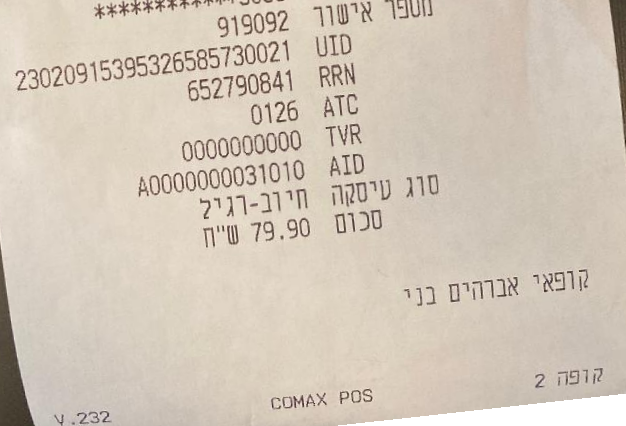

In [ ]:
alignTable_processor.getAlignTable()

In [ ]:
alignTable_processor.angle

0.48902916895416626

In [ ]:
[len(l) for l in alignTable_processor.lines[:5]]

[55, 50, 28, 28, 23]

In [ ]:
for line in  alignTable_processor.lines[:5]:
    slope = alignTable_processor.find_approximate_line(line)
    angle = alignTable_processor.calculate_angle(slope)
    print(slope, angle)

-0.021593079433657594 -1.2370000871391271
0.06437843416861945 3.6835292843522387
-0.0436535842448661 -2.499579181691691
-0.03560413492366075 -2.039105328448944
-0.04716372053092152 -2.70028113549005


In [ ]:
def applyLineSegment(mask, line, color=255):
    for i, ls in enumerate(line):
        left, bottom, right, top = ls.boundingBox
        if ls.patch is not None:
            for y in range(bottom, top):
                for x in range(left, right):
                    if ls.patch[y-bottom, x-left] > 0:
                        mask[y, x] = color
        elif ls.patch is None:
            mask[bottom:top, left:right] = color

19 <class 'lineVision.lineCv.line.LineCv_ContourLine.LineCv_ContourLine'>
9 <class 'lineVision.lineCv.line.LineCv_ContourLine.LineCv_ContourLine'>
6 <class 'lineVision.lineCv.line.LineCv_ContourLine.LineCv_ContourLine'>
6 <class 'lineVision.lineCv.line.LineCv_ContourLine.LineCv_ContourLine'>
5 <class 'lineVision.lineCv.line.LineCv_ContourLine.LineCv_ContourLine'>


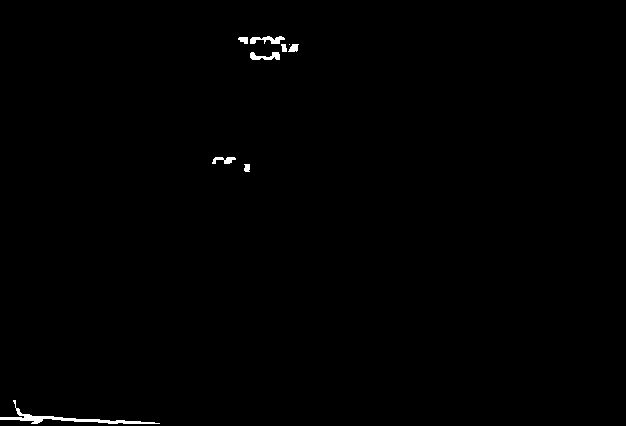

In [ ]:
mask = np.zeros(alignTable_processor.cvProcessor.imgZv.hog_shape, np.uint8)
for line in alignTable_processor.lines[:5]:
    print(len(line), type(line.parentLine))
    applyLineSegment(mask, line, color=(255))
    
Image.fromarray(mask)  

AttributeError: 'list' object has no attribute 'tolist'

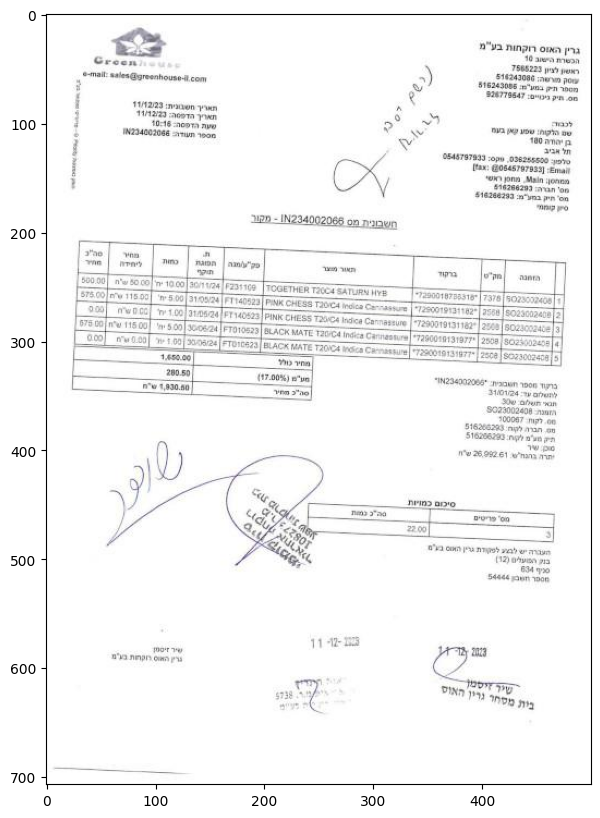

In [ ]:
# probas, boxes = tblDec.detectTables(img)

plot_results(tblDec.model, img_pil, probas, boxes)
